In [1]:
!pip install -q split-folders pytorch_lightning timm

# Import all necessary libraries

In [38]:
#models, torch, numpy
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
#drawing
import matplotlib.pyplot as plt
import zipfile
import os
from PIL import Image, ImageFile
from pathlib import Path
import glob
import shutil 
import splitfolders
import pytorch_lightning as pl
from torchmetrics import Accuracy
import timm # library for state-of-the-art image classification



from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


from tqdm.autonotebook import tqdm
from sklearn.metrics import classification_report
import warnings
import random

RAND = 21
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

random.seed(RAND)
np.random.seed(RAND)
torch.manual_seed(RAND)
torch.cuda.manual_seed(RAND)
pl.seed_everything(RAND)
torch.backends.cudnn.deterministic = True

plt.style.use('dark_background')
warnings.filterwarnings("ignore")

In [39]:
print(timm.list_models('*xception*',pretrained=True))

['legacy_xception.tf_in1k', 'xception41.tf_in1k', 'xception41p.ra3_in1k', 'xception65.ra3_in1k', 'xception65.tf_in1k', 'xception65p.ra3_in1k', 'xception71.tf_in1k']


# First look at the images

In [40]:
DATASET = Path("/kaggle/input/plates-without-bg/plates/train")

In [41]:
images = [p.resolve() for p in DATASET.glob("**/*") if p.suffix in {".png", ".jpg", ".jpeg"}]
print(len(images))

40


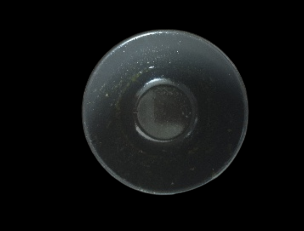

In [42]:
example_id = np.random.randint(len(images))
img = Image.open(images[example_id])
plt.imshow(img)
plt.axis("off")
plt.show()

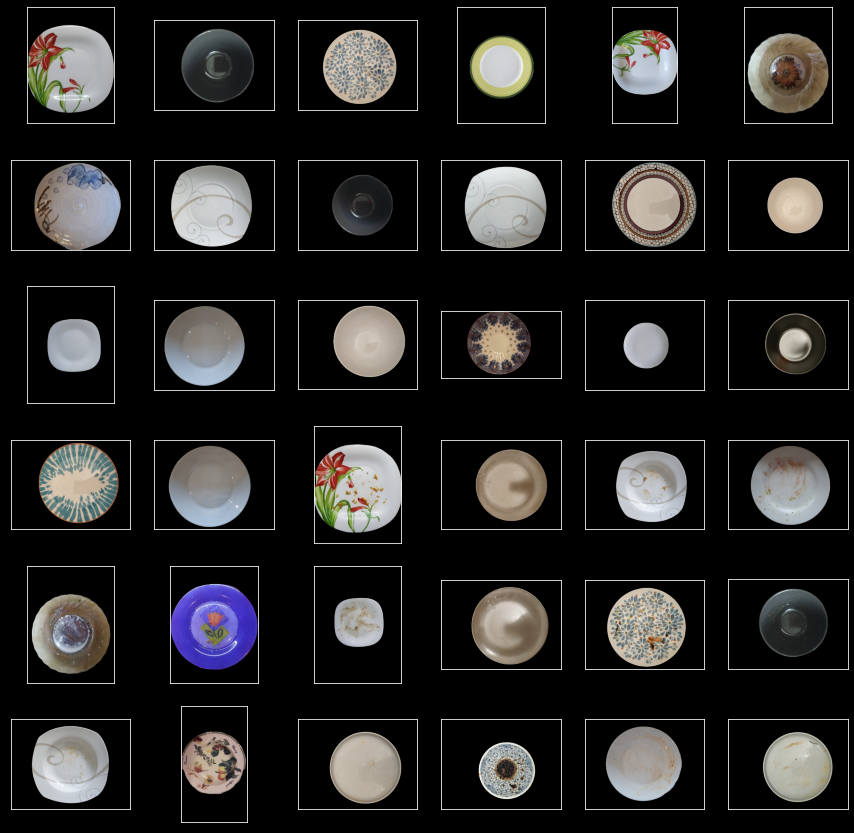

In [43]:
i = 0
plt.figure(figsize=(15,15))
for image in images[:36]:
    img = Image.open(image)
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    i += 1
plt.show()

# Train and Validation

In [44]:
# train/valid
splitfolders.ratio(
                    "/kaggle/input/plates-without-bg/plates/train",
                    output="plates_split",
                    seed=RAND,
                    ratio=(.5, .5),
                    group_prefix=None,
                    move=False
)

Copying files: 40 files [00:00, 905.79 files/s]


In [45]:
# Проверяем кол-во изображений на трейне
images = [p.resolve() for p in Path("plates_split/train").glob("**/*") if p.suffix in {".png", ".jpg", ".jpeg"}]
len(images)

28

In [46]:
!ls /kaggle/working/plates_split

train  val


# Datamodule

In [47]:
class ImageDataPrep(pl.LightningDataModule):
    def __init__(self,
                 batch_size = 8,
                 train_transform = None,
                 val_transform = None,
                 img_root = '/kaggle/working/plates_split'
                ):
        super().__init__()
        self.batch_size = batch_size
        self.train_transform = train_transform
        self.val_transform = val_transform
        self.img_root = img_root
        
        
    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=5)
    
    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=5)
    
    def setup(self, stage=None):
        self.train_set = ImageFolder(self.img_root / Path('train'), transform=self.train_transform)
        self.val_set = ImageFolder(self.img_root / Path('val'), transform=self.val_transform)

In [48]:
class TestDatasetPrep(Dataset):

    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.pictures = []
        
        for filename in sorted(glob.glob(f'{root_dir}/*')):
            im=Image.open(filename).convert('RGB')
            np_im = im
            if self.transform:
                np_im = self.transform(np_im)
            self.pictures.append(np_im)

        self.pictures = torch.stack(self.pictures)
            

    def __len__(self):
        return len(self.pictures)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = self.pictures[idx]

        return sample

In [49]:
dm = ImageDataPrep()
dm.setup()
{k:v for k, v in enumerate(dm.val_set.classes)}

{0: 'cleaned', 1: 'dirty'}

# Model Xception

Model: Xception, Optimizer: SGD

In [50]:
class Xception(pl.LightningModule):
    def __init__(self,
                 model = 'xception',
                 in_channels = 3,
                 out_classes = 2,
                 criterion = nn.BCELoss(reduction='mean'),
                 eta = 3e-4,
                 **kwargs):
        super().__init__()
        self.save_hyperparameters() # save param
        self.model = timm.create_model(model, pretrained=True, num_classes=out_classes)
        
        self.in_channels = in_channels
        self.out_classes = out_classes
        self.criterion = criterion
        self.metrics = {'accuracy': Accuracy().to(DEVICE)}
        
        
    def forward(self, x):
        return self.model(x)
        
    def shared_step(self,
                    example,
                    stage):
        x, y = example
        logits = self.forward(x.to(torch.float32))
        preds = torch.softmax(logits, dim=1)
        loss = self.criterion(preds[:,1] , y.float())
            
        return {
            'loss': loss,
            'accuracy': self.metrics['accuracy'](preds, y)
        }
            
    def shared_epoch_end(self,
                         outputs,
                         stage):
        loss = np.mean([x['loss'].item() for x in outputs])
        acc = np.mean([x['accuracy'].item() for x in outputs])
            
        metrics = {
            f'{stage}_loss': loss,
            f'{stage}_acc': acc
        }
            
        self.log_dict(metrics, prog_bar=True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr = self.hparams.eta,
        )
        
        scheduler_dict = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                patience=10
            ),
            'interval': "epoch",
            "monitor": "valid_loss"
        }
        return {'optimizer': optimizer, "lr_scheduler": scheduler_dict}
    
    def training_step(self,
                     batch,
                     batch_idx):
        return self.shared_step(batch, 'train')
    
    def training_epoch_end(self,
                     outputs):
        return self.shared_epoch_end(outputs, 'train')
    
    
    def val_step(self,
                     batch,
                     batch_idx):
        return self.shared_step(batch, 'valid')
    
    def val_epoch_end(self,
                     outputs):
        return self.shared_epoch_end(outputs, 'valid')
    
    
    def test_step(self,
                     batch,
                     batch_idx):
        return self.shared_step(batch, 'test')
    
    def test_epoch_end(self,
                     outputs):
        return self.shared_epoch_end(outputs, 'test')

# Augmentation

Vertical and horizontal flips, center crops, grayscale and color jitter

In [51]:
train_transform = transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3, fill=255),
        transforms.RandomChoice([transforms.CenterCrop(130),
                                 transforms.CenterCrop(135),
                                 transforms.CenterCrop(140),
                                 transforms.CenterCrop(125),
                                 transforms.CenterCrop(120),
                                 transforms.Compose([transforms.CenterCrop(170),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 transforms.Compose([transforms.CenterCrop(180),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 ]),
        transforms.RandomApply([
            transforms.RandomAffine((0,180), translate=(0.2, 0.2), scale=(0.3, 3), fillcolor=0)
            ],
            p=0.7
        ),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.Resize((224, 224)),
        transforms.ColorJitter(hue=(0.1, 0.3), brightness=(0.5, 1.5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3, fill=255),
        transforms.RandomChoice([transforms.CenterCrop(130),
                                 transforms.CenterCrop(135),
                                 transforms.CenterCrop(140),
                                 transforms.CenterCrop(125),
                                 transforms.CenterCrop(120),
                                 transforms.Compose([transforms.CenterCrop(170),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 transforms.Compose([transforms.CenterCrop(180),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 ]),
        transforms.RandomApply([
            transforms.RandomAffine((0,180), translate=(0.2, 0.2), scale=(0.3, 3), fillcolor=0)
            ],
            p=0.7
        ),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.Resize((224, 224)),
        transforms.ColorJitter(hue=(0.1, 0.2), brightness=(0.5, 1.5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])



dataset_transforms = {
                      'original': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])]),

                      '140': transforms.Compose([
    transforms.CenterCrop(140),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                     '135': transforms.Compose([
    transforms.CenterCrop(135),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]), 
                      '130': transforms.Compose([
    transforms.CenterCrop(130),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '125': transforms.Compose([
    transforms.CenterCrop(125),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '120': transforms.Compose([
    transforms.CenterCrop(120),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '115': transforms.Compose([
    transforms.CenterCrop(115),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '110': transforms.Compose([
    transforms.CenterCrop(110),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '105': transforms.Compose([
    transforms.CenterCrop(105),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '100': transforms.Compose([
    transforms.CenterCrop(100),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),                                               
                     }

# Fit model

In [52]:
BATCH = 4
dm = ImageDataPrep(BATCH, train_transform, test_transform)
ETA = 3*10e-3
model = Xception(eta=ETA, model='xception', out_classes=2)

callbacks = [
    ModelCheckpoint(
        dirpath='models',
        filename='{epoch}_{valid_acc:.2f}_{valid_loss:.2f}',
        save_top_k=2,
        monitor='valid_loss',
        mode='min'
    ),
    
    LearningRateMonitor(logging_interval='step'),
    EarlyStopping(monitor='valid_loss',
                  min_delta=2e-4,
                  patience=20,
                  verbose=False,
                  mode='min')
]

TENSOR = './logs'
logger = TensorBoardLogger(TENSOR, name='xception')

trainer = pl.Trainer(
    gpus=1,
    max_epochs=300,
    logger=logger,
    callbacks=callbacks,
    resume_from_checkpoint=None
)

In [53]:
trainer.fit(model, dm)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Predictions

In [54]:
pred = []
df = pd.read_csv('../input/platesv2/sample_submission.csv')
df.drop('label', axis='columns', inplace=True)

for (id, transform) in dataset_transforms.items():
    pred = []
    test_set = TestDatasetPrep('/kaggle/input/plates-without-bg/plates/test', transform=transform)
    test = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=5)
    
    model.eval()
    with torch.no_grad():
        for inputs in tqdm(test):
            inp = inputs.to(torch.float32).to(DEVICE)
            outputs = torch.softmax(model.to(DEVICE)(inp), 1)
            pred.append(outputs.detach())
        
    pred = (torch.cat(pred))[:,1].cpu().numpy()
            
    submission_df = pd.DataFrame.from_dict({'label': pred})
    
    df = pd.merge(df, submission_df, left_on='id', right_index=True)
        
df.head(8)

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

,id,label_x,label_y,label_x,label_y,label_x,label_y,label_x,label_y,label_x,label_y
0,0,0.983377,0.990622,0.989634,0.994024,0.994421,0.985517,0.984269,0.981769,0.992251,0.983098
1,1,0.962749,0.986353,0.983075,0.964011,0.967860,0.948042,0.975812,0.933896,0.930589,0.956862
2,2,0.970677,0.995260,0.995448,0.994295,0.993641,0.990816,0.992467,0.996278,0.986769,0.986436
3,3,0.947849,0.975987,0.961481,0.947771,0.969915,0.931831,0.911529,0.956748,0.911501,0.959341
4,4,0.943042,0.968300,0.967485,0.923194,0.923280,0.940807,0.969123,0.966056,0.892491,0.932505
5,5,0.997683,0.991603,0.992782,0.994805,0.993582,0.984834,0.986330,0.990244,0.982433,0.984400
6,6,0.999517,0.998066,0.998167,0.998310,0.998504,0.997518,0.995641,0.996723,0.998367,0.998148
7,7,0.961533,0.989369,0.994692,0.996411,0.997077,0.998359,0.998977,0.998088,0.998452,0.996796


Choosing the probability for dirty plates and transformation to sending to kaggle:

In [60]:
submission_df = df.copy()

submission_df['mean'] = submission_df.iloc[:, 1:].mean(axis=1)
submission_df.drop(submission_df.columns[1:-1], axis='columns', inplace=True)
submission_df['label'] = submission_df['mean'].map(lambda pred: 'dirty' if pred > 0.2 else 'cleaned')
submission_df.drop(submission_df.columns[1:-1], axis='columns', inplace=True)
submission_df.head(5)

,id,label
0,0,dirty
1,1,dirty
2,2,dirty
3,3,dirty
4,4,dirty


In [57]:
sub_df.to_csv(f'submission.csv', index=False)

In [ ]:
!rm -rf models plates_split plates logs